# Read the data and prepare multiple time series

The method of choice is the analysis given in [1] for time series' in a high dimensional space. In order to be able to process the data we have 



[1] C. Uhl, Analyse raumzeitlicher Daten strukturbildender Systeme, Verlag Shaker (1995)

Still to be found:

[2] K. Karhunen, "Zur Spektraltheorie stochastischer Prozesse," Ann. Acad. Sci. Fenn. A1, Math. Phys. 37 (1946)

[3] M. Loeve, “Fonctions aleatoires de second ordre,” Comptes Rendus De L'Académie Des Sciences, vol. 220, (1945).

### Real basis of spherical harmonics
$$ Y_{lm}=\left\{\begin{matrix}x\\ y\end{matrix}\. $$

### Load the respective libraries

In [1]:
from bs4 import BeautifulSoup
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import special
from scipy.special import sph_harm 
from scipy.special import lpmv
from scipy.special import lpmn
# nur fuer den Seiteneffekt: plt.gca(projection = '3d') funktioniert sonst nicht
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm

### Get the data

In [2]:
date='200922'
filenameC=date+'_series_covid19_confirmed_global.csv'
filenameD=date+'_series_covid19_deaths_global.csv'
filenameR=date+'_series_covid19_recovered_global.csv'
#htmlC = open("TableC.html").read()
htmlC = open(filenameC).read()
soupC = BeautifulSoup(htmlC)
TableC = soupC.find("table")
htmlD = open(filenameD).read()
soupD = BeautifulSoup(htmlD)
TableD = soupD.find("table")
htmlR = open(filenameR).read()
soupR = BeautifulSoup(htmlR)
TableR = soupR.find("table")


### Extract the header row from TableC/D/R, read data from the table and create a dictionary with all countries and the total of confirmed cases

In [3]:
# Some data of Johns Hopkins lacks the last entry being empty 
# and resulting in error of int(x)
def tryint(x):
    try:
        y=np.array([int(x[i]) for i in np.arange(len(x))])
    except ValueError:
        x[-1]=x[-2]
        y=np.array([int(x[i]) for i in np.arange(len(x))])
    return y
# TableC
# Header row
TableC_headrow= TableC.find('tr')
hcolumns = TableC_headrow.findAll('th')
output_row = []
output_rows = []
for column in hcolumns: output_row.append(column.text)
output_rows.append(output_row)
# Table
for TableC_row in TableC.findAll('tr'):
    columns = TableC_row.findAll('td')
    output_row = []
    for column in columns:
        output_row.append(column.text)
    if len(output_row) > 1: output_rows.append(output_row)
# Dictionary
yC={}
for i in np.arange(1,len(output_rows)):
    #key=output_rows[i][2]
    key=output_rows[i][1]+', '+output_rows[i][2]
    Lat=float(output_rows[i][3])
    Long=float(output_rows[i][4])
    yC[key]=np.array([np.array([Lat,Long]),tryint(output_rows[i][5:])])
    #x=output_rows[i][5:]
    #if key in yC: 
    #    yC[key]=yC[key]+tryint(x)
    #else:
    #    yC[key]=tryint(x)
# The following should be the same for all three
#x=np.arange(len(yC.get(', Germany')))
# TableD
# Header row
#TableD_headrow= TableD.find('tr')
#hcolumns = TableD_headrow.findAll('th')
#output_row = []
#output_rows = []
#for column in hcolumns: output_row.append(column.text)
#output_rows.append(output_row)
# Table
#for TableD_row in TableD.findAll('tr'):
#    columns = TableD_row.findAll('td')
#    output_row = []
#    for column in columns:
#        output_row.append(column.text)
#    if len(output_row) > 1: output_rows.append(output_row)
# Dictionary
#yD={}
#for i in np.arange(1,len(output_rows)):
#    key=output_rows[i][2]
#    x=output_rows[i][5:]
#    if key in yD: 
#        yD[key]=yD[key]+tryint(x)
#    else:
#        yD[key]=tryint(x)
# TableR
# Header row
#TableR_headrow= TableR.find('tr')
#hcolumns = TableR_headrow.findAll('th')
#output_row = []
#output_rows = []
#for column in hcolumns: output_row.append(column.text)
#output_rows.append(output_row)
# Table
#for TableR_row in TableR.findAll('tr'):
#    columns = TableR_row.findAll('td')
#    output_row = []
#    for column in columns:
#        output_row.append(column.text)
#    if len(output_row) > 1: output_rows.append(output_row)
# Dictionary
#yR={}
#for i in np.arange(1,len(output_rows)):
#    key=output_rows[i][2]
#    x=output_rows[i][5:]
#    if key in yR: 
#        yR[key]=yR[key]+tryint(x)
#    else:
#        yR[key]=tryint(x)
#
numbered=dict(zip(yC.keys(),np.arange(len(yC.keys()))))

### Save the data

In [4]:
np.save('Numbered.npy',numbered)
#
yConfirmed=np.array(list(yC.values()))
#yDeaths=np.array(list(yD.values()),dtype=float)
#yRecovered=np.array(list(yR.values()),dtype=float)
#np.savez('CDR_Data.npz',yC=yConfirmed,yD=yDeaths,yR=yRecovered)
np.savez('CD_Data.npz',yC=yConfirmed)

In [20]:
# Cast the parameters l and m in a 2D array
lmax=2
n=0
for l in np.arange(lmax+1):n+=2*l+1
lm=np.zeros((n,2),dtype=int)
i=-1
for l in np.arange(lmax+1):
    for m in np.arange(-l,l+1):
        i+=1
        lm[i]=m,l
#
# Define the real version of the SH. In scipy sph_harm phi corresponds to Long and theta to Lat
def SHreal_lm(m, l, phi_2d, theta_2d):
    if m<0:
        n=np.abs(m)
        #ylm = (np.sqrt(2.0)*(-1)**n)*sph_harm(n, l, phi_2d, theta_2d)
        ylm = sph_harm(m, l, phi_2d, theta_2d).imag
        #ylm=lpmv(n, l, np.cos(theta_2d))*np.sin(n*phi_2d)
    else:
        #print("Just before casting to real... ")
        #ylm = (np.sqrt(2.0)*(-1)**m)*sph_harm(-m, l, phi_2d, theta_2d)
        ylm = sph_harm(m, l, phi_2d, theta_2d).real
        #ylm=lpmv(m, l, np.cos(theta_2d))*np.cos(m*phi_2d)
    #else:
        #ylm = lpmv(0, l, np.cos(theta_2d))
        #ylm = sph_harm(m, l, phi_2d, theta_2d).real
    return ylm

<IPython.core.display.Javascript object>


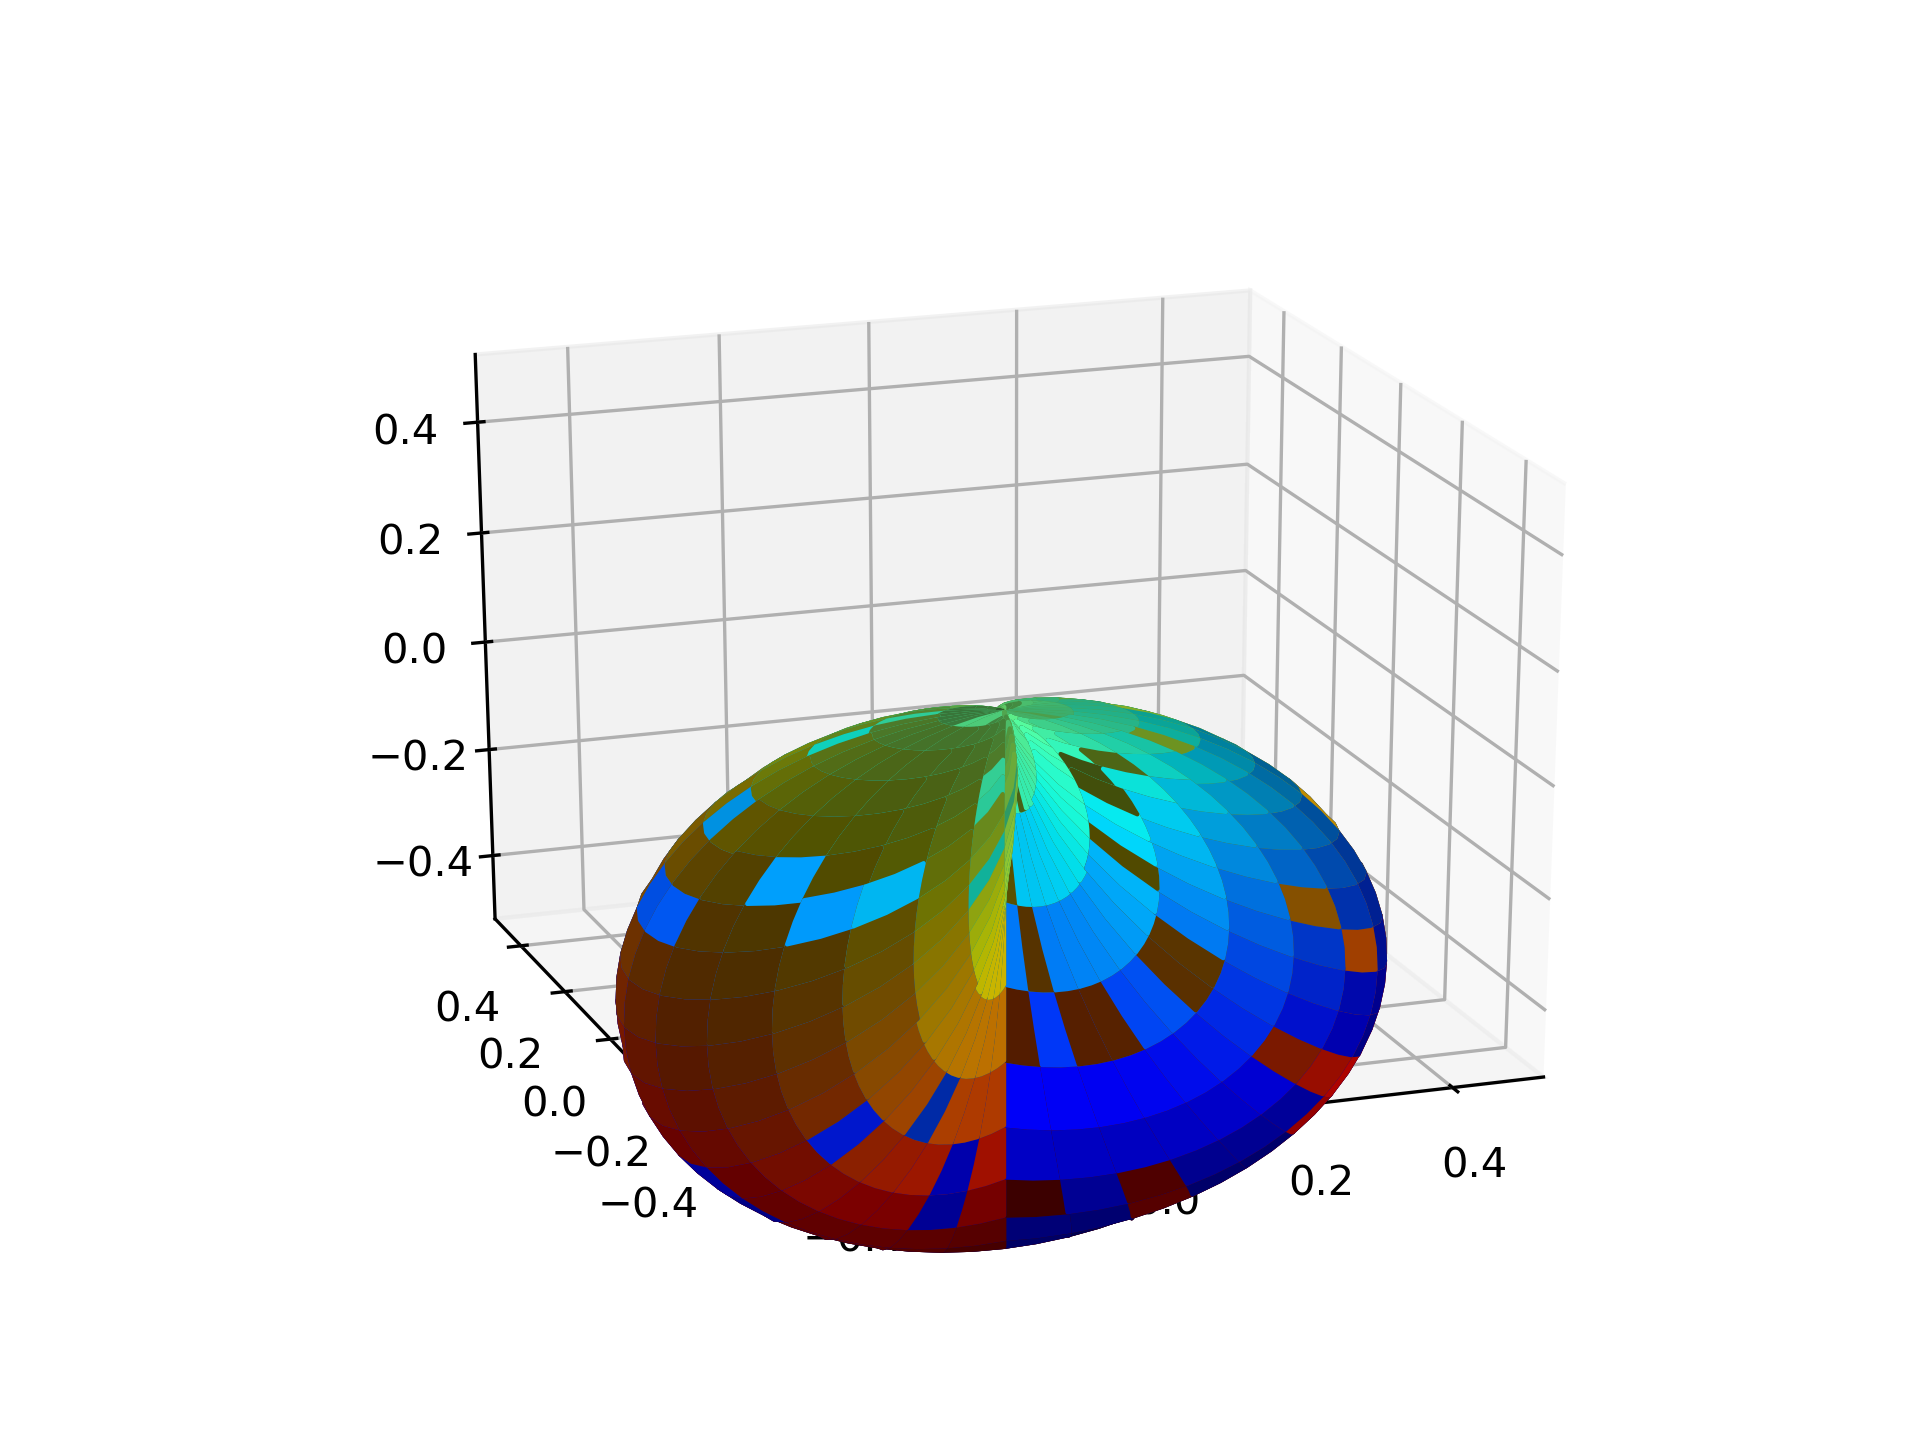

In [52]:
%matplotlib notebook
# Diese Schleifen erzeugen die Überlagerung der SH
theta_1d = np.linspace(0,   np.pi,  73) # 1/2 GRAD Schritte
phi_1d   = np.linspace(0, 2*np.pi, 73)  # 1/2 GRAD Schritte
#
theta_2d, phi_2d = np.meshgrid(theta_1d, phi_1d)
xyz_2d = np.array([np.sin(theta_2d) * np.sin(phi_2d),
                    np.sin(theta_2d) * np.cos(phi_2d),
                    np.cos(theta_2d)])
#
Y_total = sph_harm(1, 1, theta_2d, phi_2d).real

plt.figure()
ax = plt.gca(projection = "3d")
r = Y_total/np.abs(Y_total).max()*xyz_2d
#height=np.sqrt(r[0]**2+r[1]**2+r[2]**2)
height=Y_total/np.abs(Y_total).max()
height=height-height.min()
height=height/height.max()
my_col = cm.jet(height)
ax.plot_surface(r[0], r[1], r[2],facecolors=my_col,rstride=2, cstride=2)
#cs=ax.plot_surface(limit*xyz_2d[0], limit*xyz_2d[1], limit*xyz_2d[2],facecolors=my_col,rstride=2, cstride=2)
ax.set_xlim(-limit,limit)
ax.set_ylim(-limit,limit)
ax.set_zlim(-limit,limit)
#
plt.show()

In [8]:

l=len(yC)
n=yC[', Germany'][1].shape[0]
yCsnapshots=np.zeros((l,n))
yCcoordinates=np.zeros((l,2))
i=0
for key in yC.keys():
    yCsnapshots[i,:]=yC[key][1]
    Lat=np.pi*(0.5 - yC[key][0][0]/180.)
#
    if yC[key][0][1] < 0:
        Long=np.pi*(2.0 + yC[key][0][1]/180.)
    else:
        Long=np.pi*yC[key][0][1]/180.
    yCcoordinates[i]=[Lat,Long]
    i+=1

In [14]:
yC[', Germany'][0]

array([51.165691, 10.451526])

In [28]:
n=len(lm)
fYlm=np.zeros(n)
YlmYjk=np.zeros((n,n))
for i in np.arange(n):
    Ylmi=SHreal_lm(lm[i,0],lm[i,1],yCcoordinates.T[0],yCcoordinates.T[1]).real
    fYlm[i]=float(np.dot(Ylmi,yCsnapshots[:,-1]))
    for j in np.arange(n):
        Yjk=SHreal_lm(lm[j,0],lm[j,1],yCcoordinates.T[0],yCcoordinates.T[1]).real
        YlmYjk[i,j]=np.dot(Ylmi,Yjk)

In [29]:
alpha=np.linalg.solve(YlmYjk,fYlm)
np.allclose(np.dot(YlmYjk, alpha), fYlm)

True

<IPython.core.display.Javascript object>


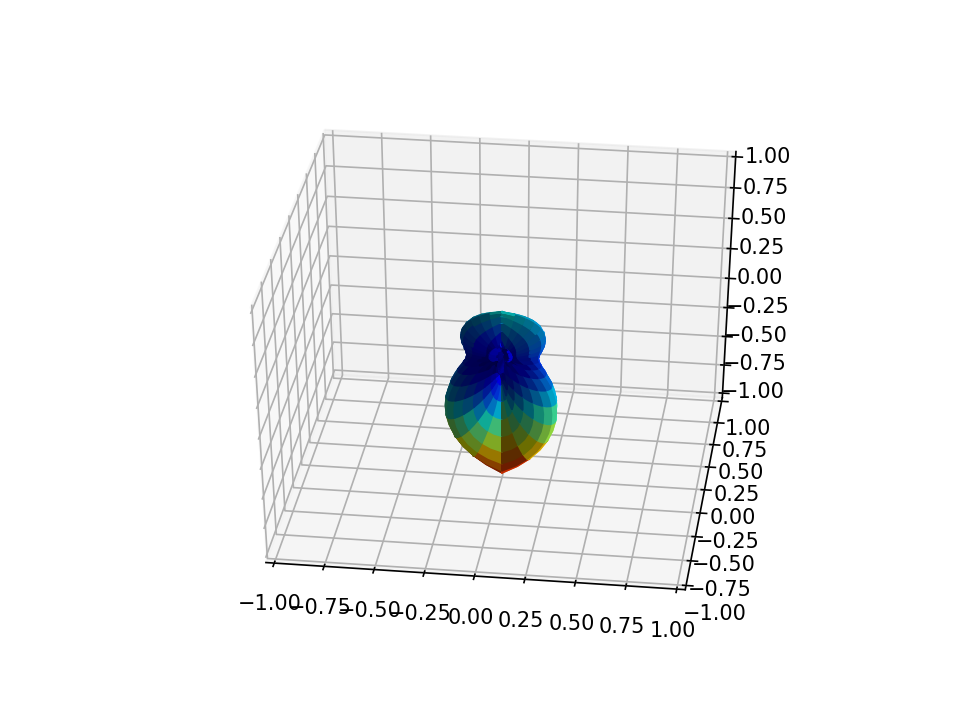

In [32]:
%matplotlib notebook
# Diese Schleifen erzeugen die Überlagerung der SH
theta_1d = np.linspace(0,   np.pi,  37) # 1/2 GRAD Schritte
phi_1d   = np.linspace(0, 2*np.pi, 73)  # 1/2 GRAD Schritte
#
theta_2d, phi_2d = np.meshgrid(theta_1d, phi_1d)
xyz_2d = np.array([np.sin(theta_2d) * np.sin(phi_2d),
                    np.sin(theta_2d) * np.cos(phi_2d),
                    np.cos(theta_2d)])

colormap = cm.ScalarMappable( cmap=plt.get_cmap("cool"))
colormap.set_clim(-.45, .45)
limit = 1.
#
Y_total = SHreal_lm(-1, 1, theta_2d, phi_2d).real
Y_total=np.zeros(theta_2d.shape)
for i in np.arange(0,n):
    Y_total+=alpha[i]*SHreal_lm(lm[i,0], lm[i,1], theta_2d, phi_2d).real
#
plt.figure()
ax = plt.gca(projection = "3d")
r = np.abs(Y_total/Y_total.max())*xyz_2d
height=np.sqrt(r[0]**2+r[1]**2+r[2]**2)
height=height-height.min()
height=height/height.max()
my_col = cm.jet(height)
ax.plot_surface(r[0], r[1], r[2],facecolors=my_col,rstride=2, cstride=2)
#cs=ax.plot_surface(limit*xyz_2d[0], limit*xyz_2d[1], limit*xyz_2d[2],facecolors=my_col,rstride=2, cstride=2)
ax.set_xlim(-limit,limit)
ax.set_ylim(-limit,limit)
ax.set_zlim(-limit,limit)
#
plt.show()

In [ ]:
# Dictionary
yCases={}
for i in np.arange(1,len(output_rows)):
    if output_rows[i][1] != '': 
        key=output_rows[i][1]+', '+output_rows[i][2]
    else:
        key=', '+output_rows[i][2]
    yCases[key]=tryint(output_rows[i][5:])

In [ ]:
np.argwhere(np.isnan(yCsnapshots.reshape(yCsnapshots.shape[0]*yCsnapshots.shape[1])))

In [23]:
Y_total.max()

0.0

In [24]:
Y_total.min()

-0.3454941494713355

In [ ]:
%matplotlib notebook
plt.plot(theta_1d,lpmv(1,1,np.cos(theta_1d)))

In [ ]:
lpmv(1,1,np.cos(theta_1d))

In [6]:
SHreal_lm(-1,1,np.pi/2.,0.1)

0.09983341664682872

In [30]:
alpha

array([1561513.79337962, 1361378.60831797,  -74482.61662598,
        859437.51058393, -397630.30433197, -185253.90841845,
       -580319.43870217, -320193.77642497,  -27991.34165777])

In [43]:
def show_Y_lm(l, m):
    print("Y_%i_%i" % (l,m)) # zeigen, dass was passiert
    plt.figure()
    ax = plt.gca(projection = "3d")
    
    plt.title("$Y^{%i}_{%i}$" % (m,l))
    if m<0: 
        Y_lm = sph_harm(m,l, phi_2d, theta_2d).imag
    else:
        Y_lm = sph_harm(m,l, phi_2d, theta_2d).real
    r = np.abs(Y_lm.real)*xyz_2d
    ax.plot_surface(r[0], r[1], r[2], 
                    facecolors=colormap.to_rgba(Y_lm.real), 
                    rstride=2, cstride=2)
    ax.set_xlim(-limit,limit)
    ax.set_ylim(-limit,limit)
    ax.set_zlim(-limit,limit)
    #ax.set_axis_off()

Y_-1_1


<IPython.core.display.Javascript object>


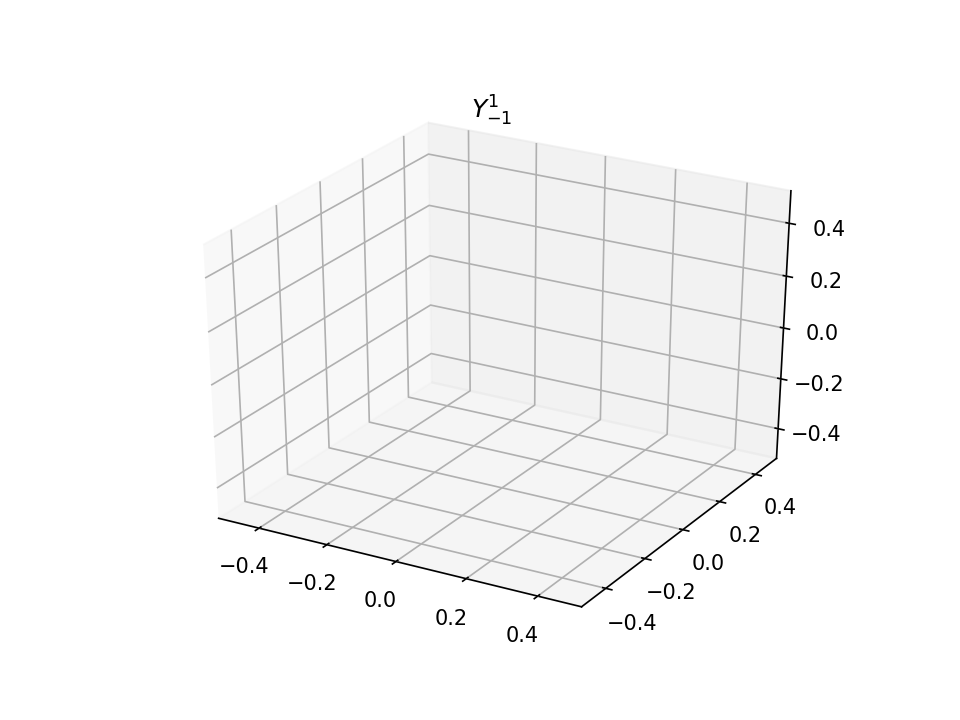

/Users/greiner/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  


In [47]:

show_Y_lm(-1,1)

In [36]:
np.abs(sph_harm(1,1,theta_2d,phi_2d).real)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0301118 , 0.02999721, 0.02965433, ..., 0.02965433, 0.02999721,
        0.0301118 ],
       [0.05999443, 0.05976613, 0.05908298, ..., 0.05908298, 0.05976613,
        0.05999443],
       ...,
       [0.05999443, 0.05976613, 0.05908298, ..., 0.05908298, 0.05976613,
        0.05999443],
       [0.0301118 , 0.02999721, 0.02965433, ..., 0.02965433, 0.02999721,
        0.0301118 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [46]:
sph_harm(-1,1, phi_2d, theta_2d).imag

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.62441623e-03, -5.22885906e-03, ...,
        -5.22885906e-03, -2.62441623e-03,  0.00000000e+00],
       [ 0.00000000e+00, -5.22885906e-03, -1.04179233e-02, ...,
        -1.04179233e-02, -5.22885906e-03,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  5.22885906e-03,  1.04179233e-02, ...,
         1.04179233e-02,  5.22885906e-03,  0.00000000e+00],
       [ 0.00000000e+00,  2.62441623e-03,  5.22885906e-03, ...,
         5.22885906e-03,  2.62441623e-03,  0.00000000e+00],
       [ 0.00000000e+00,  7.37526370e-18,  1.46943972e-17, ...,
         1.46943972e-17,  7.37526370e-18,  0.00000000e+00]])

In [22]:
yC[', Germany'][1][243]

275560